In [1]:
#importation
import pandas as pd
from fastai.vision.utils import get_image_files #allow to collect images from a repertory and to display it
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
#importation of datasets
train = pd.read_csv('train.csv')


In [3]:
train.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
train.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
#collect of images

train_images_path = "train/train"
test_images_path = "test/test"

train_images = get_image_files(train_images_path)
test_images = get_image_files(test_images_path)

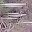

In [6]:
im = Image.open(train_images[0])
im

has_cactus
1    13136
0     4364
Name: count, dtype: int64


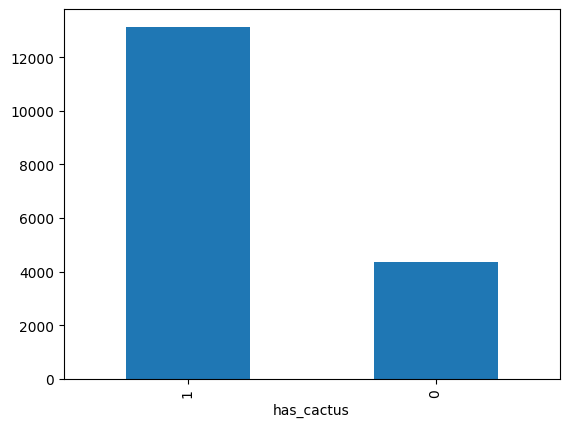

In [7]:
#data distribution
train['has_cactus'].value_counts().plot(kind='bar')
print(train['has_cactus'].value_counts())

#we need to balance the dataset...


In [8]:
##normlization of the images and take the name of the images

normalized_images = []
normalized_images_names = []
train_images = get_image_files('train/train')

for image_path in train_images:
    im = Image.open(image_path)
    im_array = np.array(im)
    im_array = im_array.astype('float32') / 255.0
    normalized_images.append(im_array)
    normalized_images_names.append(os.path.basename(image_path)) # add the name to the list in order to if there are cactus or no


In [9]:
print(normalized_images_names[0])

0004be2cfeaba1c0361d39e2b000257b.jpg


In [10]:
normalized_images[0].shape
#normalized_images[0][0]

(32, 32, 3)

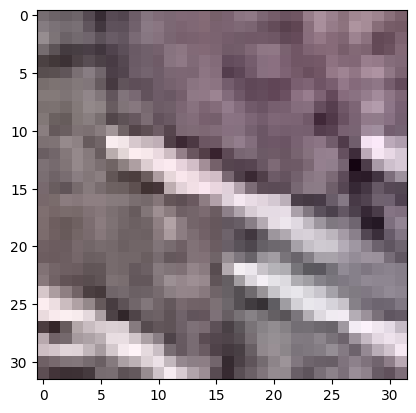

In [11]:
plt.show(plt.imshow(normalized_images[1]))

In [12]:
#separate images with cactus and without cactus

#Create a dictionary to map image names to their indice
name_to_index = {os.path.basename(image_path): idx for idx, image_path in enumerate(train_images)}
df_noCactus = [] #images without cactus
df_noCactus_name = [] #names of images without cactus

for index, row in train.iterrows():
    if row['has_cactus'] == 0:
        image_name = row['id']
        image_index = name_to_index[image_name] #use the dictionary to find the corresponding index


        df_noCactus_name.append(normalized_images_names[image_index])
        df_noCactus.append(normalized_images[image_index])

In [13]:
len(df_noCactus)

4364

In [14]:
##random oversampling

def add_noise(img,variance=0.1,mean=0):
    """add gaussian noise to an image"""
    noise = np.random.normal(mean, variance, img.shape)
    img += noise
    img = np.clip(img, 0., 1.)
    return img

def rotation(img, angle=90):
    """rotate an image by a given angle in degrees"""
    return np.rot90(img, k=angle//90)

def luminosity(img, factor=1):
    """change the luminosity of an image"""
    return np.clip(img * factor, 0., 1.)




In [15]:
def modified_image(im):
    """apply random transformations to an image"""
    im = im.copy()
    if np.random.rand() < 0.5:
        im = rotation(im, angle=np.random.choice([90, 180, 270]))
    if np.random.rand() < 0.5:
        im = luminosity(im, factor=np.random.uniform(0.5, 1.5))
    if np.random.rand() < 0.5:
        im = add_noise(im, variance=np.random.uniform(0, 0.05))
    return im

In [16]:
###new images of no cactus
new_images = [] #new images of no cactus
number_of_image=train['has_cactus'].value_counts()[1]-train['has_cactus'].value_counts()[0]
for k in range(number_of_image):
    p = np.random.randint(0, len(df_noCactus))
    new_images.append(modified_image(df_noCactus[p]))

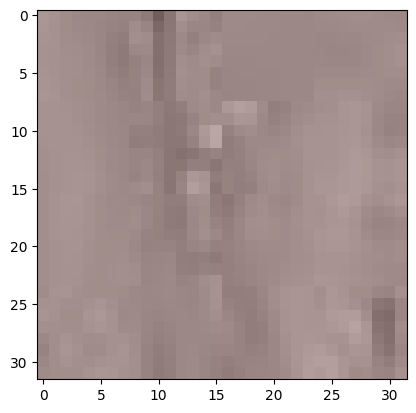

8772


In [17]:
plt.show(plt.imshow(new_images[2]))
print(len(new_images))

In [18]:
##create a new dataset with the new images
new_images_id=np.zeros(len(new_images))
new_images_has_cactus=np.zeros(len(new_images))

##concatenate the new images with the old images
new_images=np.array(new_images)
normalized_images=np.array(normalized_images)
df_Cactus=np.concatenate((normalized_images,new_images),axis=0)

new_images_name=np.array(new_images_id)
normalized_images_names=np.array(normalized_images_names)
df_Cactus_id=np.concatenate((normalized_images_names,new_images_name),axis=0)

has_cactus=train['has_cactus'].to_numpy()
new_images_has_cactus=np.concatenate((has_cactus,new_images_has_cactus),axis=0)

# flatten the images
#df_Cactus_list = [img.flatten().tolist() for img in df_Cactus]

#print the shape of the new dataset
print(df_Cactus.shape)



(26272, 32, 32, 3)


In [19]:
print("there are :",np.sum(new_images_has_cactus),"cactus and ",len(new_images_has_cactus)-np.sum(new_images_has_cactus),"no cactus")

there are : 13136.0 cactus and  13136.0 no cactus


# Deep Learning

1. df_cactus: balanced dataset of images normalized
2. new_images_has_cactus: labels of images

In [146]:
##Importation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [147]:
##Parameters

batch_size = 32
image_height = 32
image_width = 32
n_classes=2

In [154]:
#convert list in tensor
images_tensor = tf.convert_to_tensor(df_Cactus, dtype=tf.float32)
labels_tensor = tf.convert_to_tensor(new_images_has_cactus, dtype=tf.float32)

#create a dataset
dataset = tf.data.Dataset.from_tensor_slices((images_tensor, labels_tensor))

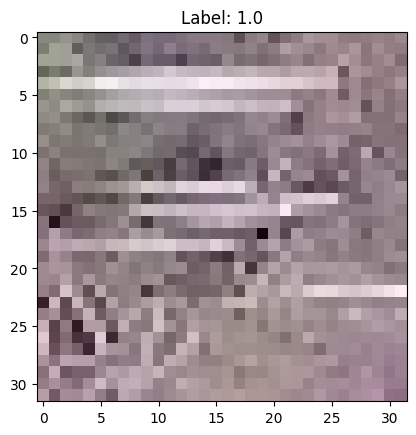

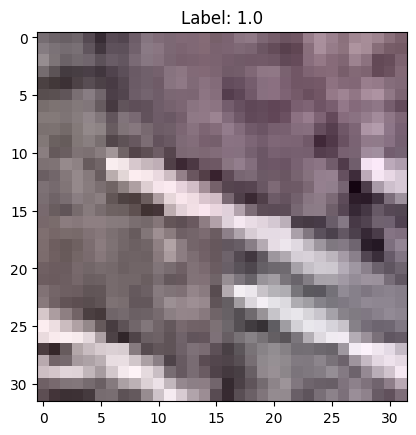

In [125]:
import matplotlib.pyplot as plt

# Print the first 2 images and labels
for images, labels in dataset.take(2):
    plt.imshow(images.numpy())
    plt.title(f'Label: {labels.numpy()}')
    plt.show()

In [167]:
#shuffle the dataset
dataset = dataset.shuffle(buffer_size=1024).repeat()

In [168]:
#divided into train and validation
train_size = int(0.8 * len(df_Cactus))
val_size = int(0.2 * len(df_Cactus))
train_dataset = dataset.take(train_size).batch(batch_size)
val_dataset = dataset.skip(train_size).batch(batch_size)

In [169]:
print(train_dataset.element_spec)

(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))


In [170]:
#model deep learning

model = tf.keras.Sequential([
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [171]:
#compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [172]:
logdir="logs"

tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_images=logdir,
                                                   embeddings_data=train_dataset)


In [173]:
images=dataset.take(1)
print(images)

<_TakeDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [174]:
#fit the model
model.fit( 
    train_dataset,
  validation_data=val_dataset,
  epochs=1,
  callbacks=[tensorboard_callback]
)

C:\Users\Victor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\backend.py:5703: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


655/657 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9146

ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).

In [176]:
#evaluation
model.evaluate(val_dataset, steps=200)


200/200 [==============================] - 1s 5ms/step - loss: 0.1627 - accuracy: 0.9391


[0.16274504363536835, 0.9390624761581421]

In [116]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 30, 30, 128)       3584      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 15, 15, 128)      0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 13, 13, 64)        73792     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 6, 6, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 4, 4, 32)          18464     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 2, 2, 32)        

# Evaluation

In [102]:
##normlization of the images and take the name of the images

normalized_test_images = []
normalized_test_images_names = []
test_images = get_image_files('test/test')

for image_path in test_images:
    im = Image.open(image_path)
    im_array = np.array(im)
    normalized_test_images.append(im_array)
    normalized_test_images_names.append(os.path.basename(image_path)) 

In [103]:
#open csv file
submission = pd.read_csv('sample_submission.csv')
print(submission.head())

                                     id  has_cactus
0  000940378805c44108d287872b2f04ce.jpg         0.5
1  0017242f54ececa4512b4d7937d1e21e.jpg         0.5
2  001ee6d8564003107853118ab87df407.jpg         0.5
3  002e175c3c1e060769475f52182583d0.jpg         0.5
4  0036e44a7e8f7218e9bc7bf8137e4943.jpg         0.5
